# 1. Load Dependency

In [1]:
!git clone https://github.com/VinceTruong/Data_Mining.git

Cloning into 'Data_Mining'...
remote: Enumerating objects: 45086, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 45086 (delta 5), reused 11 (delta 2), pack-reused 45070
Receiving objects: 100% (45086/45086), 63.56 MiB | 24.79 MiB/s, done.
Resolving deltas: 100% (113/113), done.
Updating files: 100% (115851/115851), done.


In [25]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc, accuracy_score
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform

from keras.models import Sequential
from keras import regularizers
from keras.layers import RandomFlip, RandomZoom, AveragePooling2D, Add, Dense, Conv2D, MaxPool2D , Flatten, Dropout, BatchNormalization, Input, ZeroPadding2D, Activation, MaxPooling2D

import warnings
warnings.filterwarnings("ignore")

In [3]:
train_path = "Data_Mining/dataset_aug/train"
test_ds = "Data_Mining/dataset_aug/test"

# 2. Load and explore dataset

## 2.1 Load augmentation data

In [4]:
# The data consists of 48x48 pixel grayscale images of faces.
batch_size = 256
img_height = 48
img_width = 48

In [5]:
# Load train, validation, test from directory
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory = train_path,
    labels = "inferred",
    validation_split = 0.2,
    subset = 'training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale',
    label_mode="categorical")

val_ds = tf.keras.utils.image_dataset_from_directory(
    directory = train_path,
    labels = "inferred",
    validation_split = 0.2,
    subset = 'validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale',
    label_mode="categorical")

test_ds = tf.keras.utils.image_dataset_from_directory(
    directory = test_ds,
    labels = "inferred",
    seed=123,
    image_size=(img_height, img_width),
    #batch_size=batch_size,
    color_mode='grayscale',
    label_mode="categorical")

Found 31970 files belonging to 7 classes.
Using 25576 files for training.


2022-12-06 08:46:28.229846: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 08:46:28.231269: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 08:46:28.236615: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 08:46:28.238021: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 08:46:28.239138: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Found 31970 files belonging to 7 classes.
Using 6394 files for validation.
Found 7101 files belonging to 7 classes.


In [6]:
train_ds_normal = train_ds.map(lambda x,y: (x/255, y))
val_ds_normal = val_ds.map(lambda x,y: (x/255, y))
test_ds_normal = test_ds.map(lambda x,y: (x/255, y))

In [7]:
#train dataset
trainX, trainY = zip(*train_ds)
trainX = np.concatenate([x for x in trainX], axis = 0)
trainY = np.concatenate([y for y in trainY], axis = 0)
#validation dataset
valX, valY = tuple(zip(*val_ds))
valX = np.concatenate([x for x in valX], axis = 0)
valY = np.concatenate([y for y in valY], axis = 0)
#test datasett
testX, testY = tuple(zip(*test_ds))
testX = np.concatenate([x for x in testX], axis = 0)
testY = np.concatenate([y for y in testY], axis = 0)

2022-12-06 08:46:34.490605: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


## 2.2 Data Visualization

In [8]:
train_category = list(np.sum(trainY, axis=0).astype('int64'))
test_category = list(np.sum(testY, axis=0).astype('int64'))
facial_train = ['happy', 'neutral', 'sad', 'fear', 'angry', 'disgust','surprise']
facial_test = ['happy', 'neutral', 'sad', 'fear', 'angry', 'surprise', 'disgust']

In [9]:
train_category.sort(reverse=True)
dic_train = {facial_train[i]: train_category[i] for i in range(7)}

test_category.sort(reverse=True)
dic_test = {facial_test[i]: test_category[i] for i in range(7)}

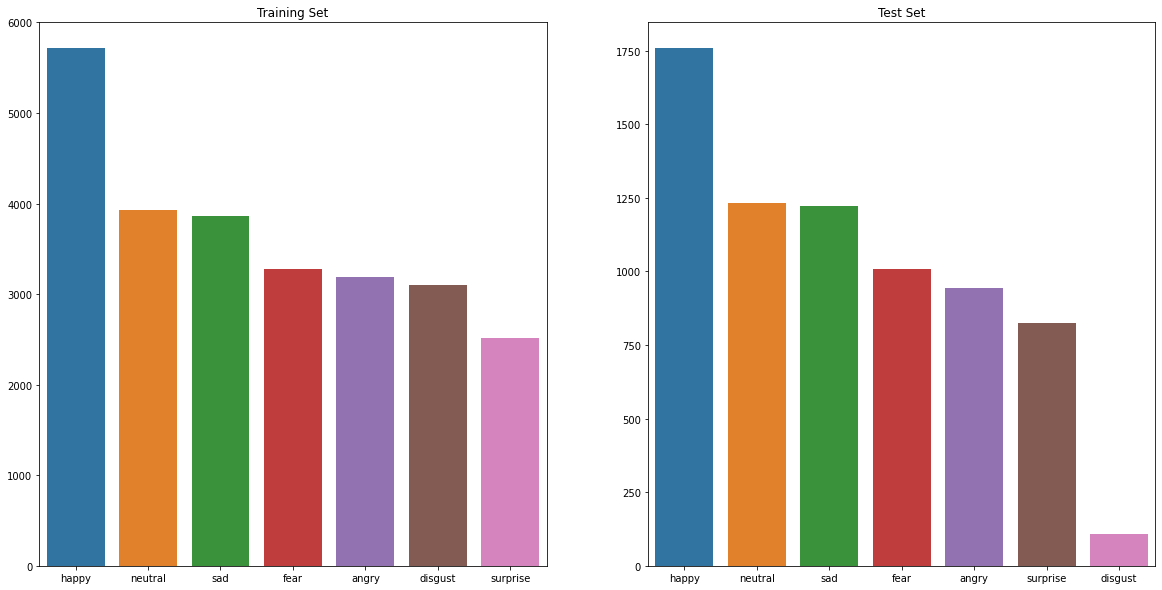

In [10]:
#Training and test set
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
sns.barplot(x = list(dic_train.keys()), y = list(dic_train.values()), ax = ax[0])
ax[0].title.set_text('Training Set')
sns.barplot(x = list(dic_test.keys()), y = list(dic_test.values()), ax = ax[1])
ax[1].title.set_text('Test Set')

# 3. VGG16 Model Tuning


## 3.1 Define some Plot functions

In [11]:
y_test = np.argmax(testY, axis = 1)

We change batch size to 256 to speed up the training time. Also, learning rate become 0.0001 to ensure VGG16 model can reach the global minimum

In [12]:
args = {
    "epochs": 20,
    "batches": 256,
    "lr": 0.0001
}
adm = Adam(learning_rate=args["lr"])

In [13]:
# roc_curve definition
def plot_multiclass_roc(y_predict, y_test):

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    
    for i in range(7):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_predict[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=(10,10))
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(7):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %s' % (roc_auc[i], test_ds.class_names[i]))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

#plot_multiclass_roc()

In [14]:
# confustion matrix for model result
def plot_confusion_matrix(actual, predicted, labels, ds_type):
    cm = tf.math.confusion_matrix(actual, predicted)
    ax = sns.heatmap(cm, annot=True, fmt='g', cmap = 'Blues')
    sns.set(rc={'figure.figsize':(10, 10)})
    sns.set(font_scale=1.4)
    ax.set_title('Confusion matrix of action recognition for ' + ds_type)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0) 
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    
labels = ['angry', 'digust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

## 3.2 VGG16

In [26]:
# Creating model
VGG = Sequential()

# 2 x convolution layer of 64 filters of size 3x3  +  1 x maxpool layer 2x2
VGG.add(Conv2D(input_shape=((48, 48, 1)),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
VGG.add(RandomFlip("horizontal"))
VGG.add(RandomZoom(0.2, 0.3))
VGG.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
VGG.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


# 2 x convolution layer of 128 filters of size 3x3  +  1 x maxpool layer 2x2
VGG.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


# 3 x convolution layer of 256 filters of size 3x3  +  1 x maxpool layer 2x2
VGG.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


# 3 x convolution layer of 512 filters of size 3x3  +  1 x maxpool layer 2x2
VGG.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


# 3 x convolution layer of 512 filters of size 3x3  +  1 x maxpool layer 2x2
VGG.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


# After several convolution layers and pooling layer, data has been flatten and loaded into fully connected layer
# 2 x Dense layers of 4096 units  +  1 x Dense Softmax layer of 7 units
VGG.add(Flatten())
VGG.add(Dense(units=4096,activation="relu"))
VGG.add(Dense(units=4096,activation="relu"))
VGG.add(Dense(units=7, activation="softmax"))

In [27]:
VGG.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 48, 48, 64)        640       
_________________________________________________________________
random_flip (RandomFlip)     (None, 48, 48, 64)        0         
_________________________________________________________________
random_zoom_1 (RandomZoom)   (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 48, 48, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 24, 24, 128)      

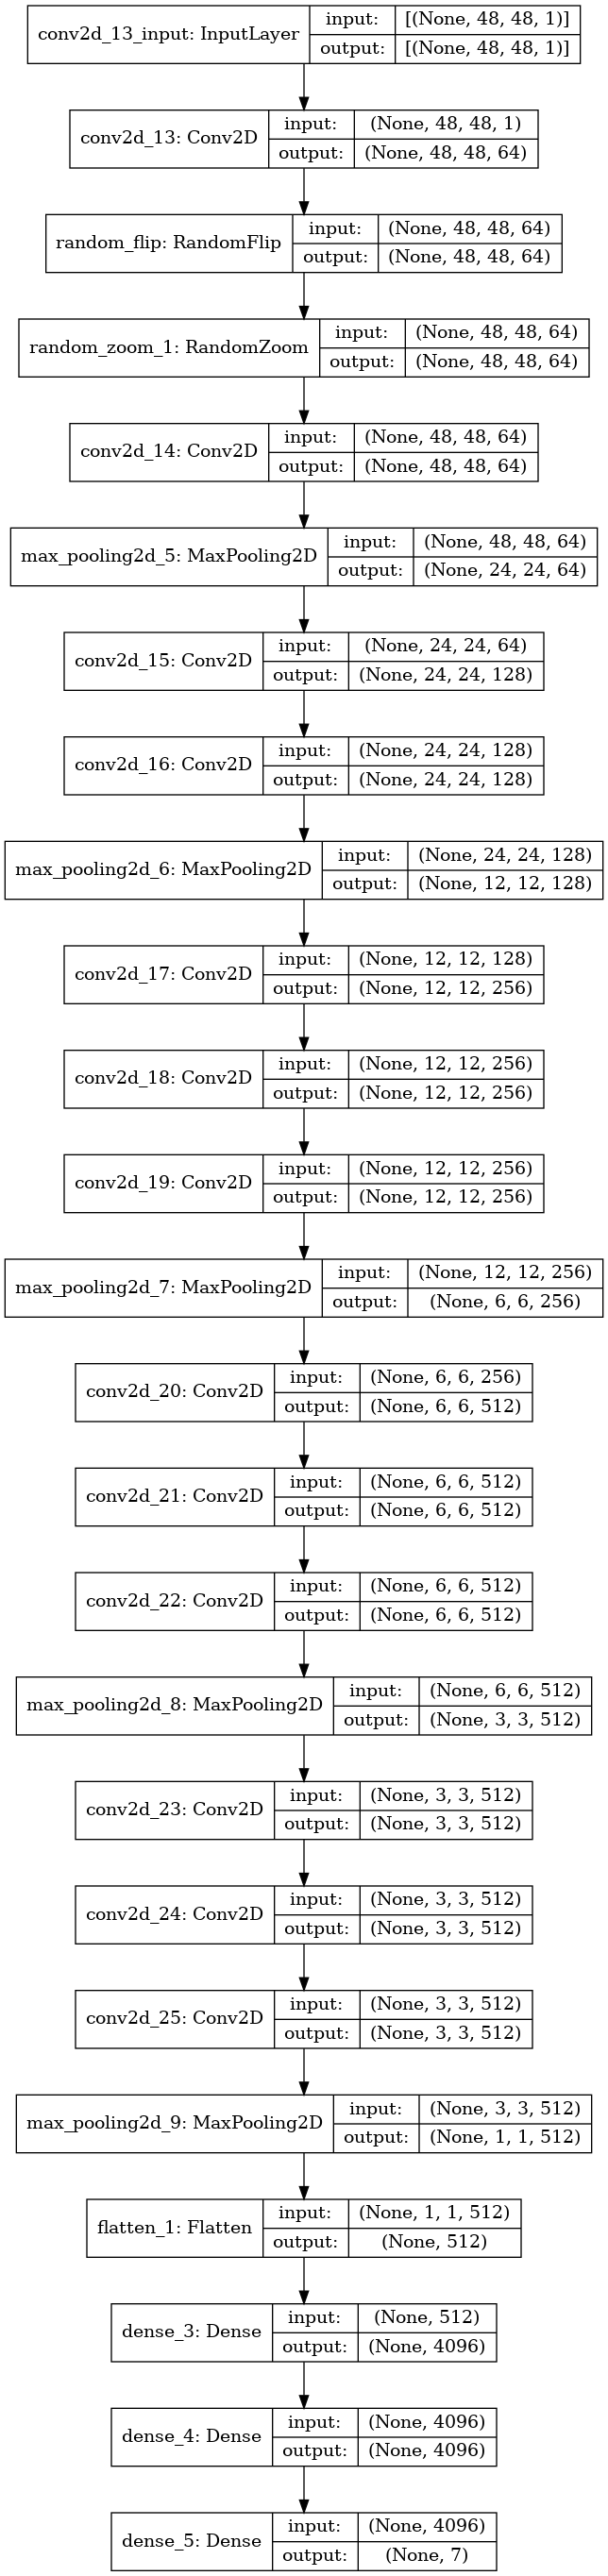

In [28]:
plot_model(VGG, show_shapes=True, show_layer_names=True)

In [29]:
# Saving Checkpoint 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=5)

check_point = ModelCheckpoint(filepath='VGG.hdf5', monitor='val_loss', save_best_only=True)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

callbacks = [reduce_lr, check_point, early_stop]

[Start training]...
Epoch 1/20
100/100 [==============================] - 27s 262ms/step - loss: 1.8841 - accuracy: 0.2369 - val_loss: 1.7788 - val_accuracy: 0.3137
Epoch 2/20
100/100 [==============================] - 25s 248ms/step - loss: 1.6807 - accuracy: 0.3536 - val_loss: 1.5612 - val_accuracy: 0.4102
Epoch 3/20
100/100 [==============================] - 24s 242ms/step - loss: 1.5189 - accuracy: 0.4235 - val_loss: 1.4501 - val_accuracy: 0.4475
Epoch 4/20
100/100 [==============================] - 25s 249ms/step - loss: 1.4025 - accuracy: 0.4668 - val_loss: 1.3076 - val_accuracy: 0.5102
Epoch 5/20
100/100 [==============================] - 25s 251ms/step - loss: 1.3228 - accuracy: 0.5008 - val_loss: 1.2467 - val_accuracy: 0.5241
Epoch 6/20
100/100 [==============================] - 25s 247ms/step - loss: 1.2498 - accuracy: 0.5270 - val_loss: 1.1892 - val_accuracy: 0.5449
Epoch 7/20
100/100 [==============================] - 25s 247ms/step - loss: 1.1930 - accuracy: 0.5478 - val_l

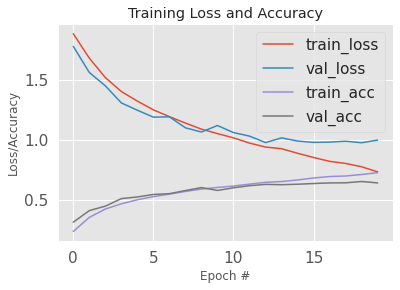

In [30]:
tic = time.perf_counter()

# train the model using Adam
print("[Start training]...")
adm = Adam(learning_rate=args["lr"])

VGG.compile(loss="categorical_crossentropy", optimizer=adm, metrics=["accuracy"])
H = VGG.fit(x = trainX, y= trainY, validation_data=(valX, valY), epochs=args["epochs"], batch_size=args["batches"], callbacks=callbacks)

toc = time.perf_counter()    # stop timer
print(f"\nTraining completed in {(toc - tic)/60:0.4f} minutes\n")


# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, args["epochs"]), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, args["epochs"]), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, args["epochs"]), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, args["epochs"]), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [31]:
y_predict_vgg = VGG.predict(testX)
y_predict_vgg_label = np.argmax(y_predict_vgg, axis = 1)

In [32]:
# accuracy
accuracy_score(y_test, y_predict_vgg_label)

0.5966765244331784

In [33]:
# classification report
print(classification_report(y_test, y_predict_vgg_label, target_names = labels))

              precision    recall  f1-score   support

       angry       0.48      0.57      0.52       944
      digust       0.50      0.51      0.50       108
        fear       0.43      0.38      0.40      1007
       happy       0.85      0.80      0.82      1759
     neutral       0.53      0.61      0.56      1223
         sad       0.46      0.45      0.45      1234
    surprise       0.77      0.70      0.73       826

    accuracy                           0.60      7101
   macro avg       0.57      0.57      0.57      7101
weighted avg       0.60      0.60      0.60      7101



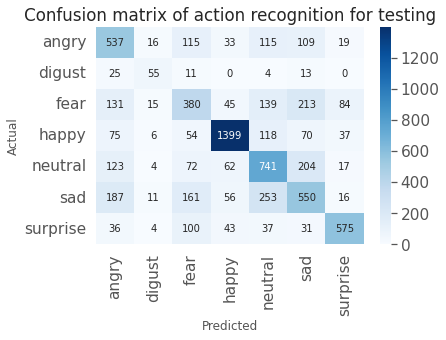

In [34]:
# confision matrix
plot_confusion_matrix(y_test, y_predict_vgg_label, labels, 'testing')

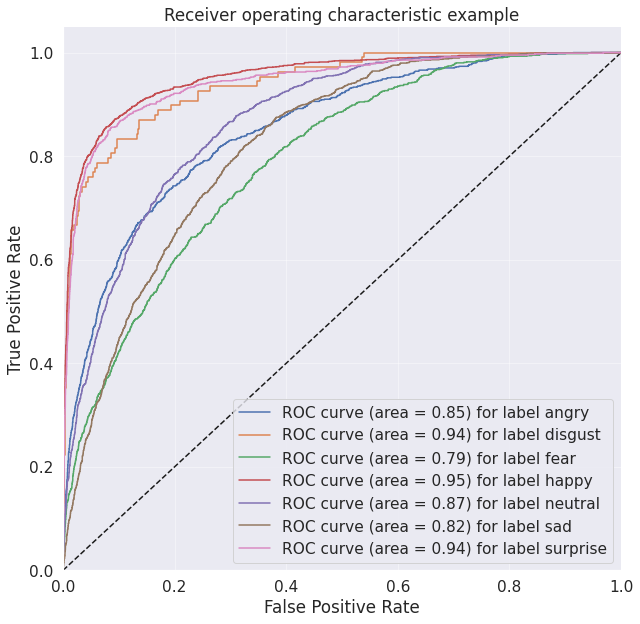

In [35]:
# ROC 
plot_multiclass_roc(y_predict_vgg, testY)